In [21]:
#Work with fts files http://eso-python.github.io/ESOPythonTutorials/FITS-images.html
#Rotate matrix https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.rotate.html

Assignment #1 
Derivation of solar differential rotation from measuring sunspot positions
Team members

Valerii Serpiva MSC1 Space and engineering system. 
Valerii.Serpiva@skoltech.ru

Daniel Kekere Engineering systems. 
daniel.kekere@skoltech.ru 

In [25]:
import pyfits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import os
import datetime
import astropy
from scipy import ndimage, misc
from astropy.utils.data import download_file
from astropy.modeling.rotations import Rotation2D
from astropy.io import fits
from datetime import datetime
%matplotlib inline

In [26]:
#Fuctions
def open_rts(files, directory, k):
    for i in range(k):
        files[i] = directory + '/' + files[i] 
    hdu_list = fits.open(files[0]) 
    for i in range(k):
        hdu_list2 = fits.open(files[i])  
        hdu_list.append(hdu_list2[0])
    return hdu_list

def time_extract(datas):
    #DATA AND TIME EXTRACT FROM STRING LIST
    #format input data 2016-06-10T10:42:07
    s = datas
    l = len(s)
    integ = []
    i = 0
    while i < l:
        s_int = ''
        a = s[i]
        while '0' <= a <= '9':
            s_int += a
            i += 1
            if i < l:
                a = s[i]
            else:
                break
        i += 1
        if s_int != '':
            integ.append(int(s_int))
    return integ

def extract_date_from_hdu (hdu_list, k):  
    DATE_OBS_str = np.array(range(0, k), dtype = 'object')
    DATE_OBS = np.array(range(0, k), dtype = 'object')
    day_obs = np.array(range(0, k), int)
    CENTER_Y = np.array(range(0, k), float)
    CENTER_Z = np.array(range(0, k), float)
    SOLAR_P0 = np.array(range(0, k), float)
    SOLAR_R = np.array(range(0, k), float)
    ANGLE = np.array(range(0, k), float)
    for i in range(0, k):
        DATE_OBS_str[i] = hdu_list[i+1].header['DATE-OBS']
        SOLAR_P0[i] = hdu_list[i+1].header['SOLAR_P0']
        SOLAR_R[i] = hdu_list[i+1].header['SOLAR_R']
        CENTER_Y[i] = hdu_list[i+1].header['CENTER_X']
        CENTER_Z[i] = hdu_list[i+1].header['CENTER_Y']
        ANGLE[i] = hdu_list[i+1].header['ANGLE']
    for i in range(0, k):
        DATE_OBS[i] = time_extract(DATE_OBS_str[i])
        day_obs[i] = DATE_OBS[i][2] #Day obs for ploting
    return DATE_OBS, SOLAR_P0, SOLAR_R, CENTER_Y, CENTER_Z, day_obs, ANGLE

def safe_images_to_png (hdu_list, SOLAR_P0, k, name):
    for i in range(0, k):
        im1 = hdu_list[i+1].data
        im1 = np.flipud(im1)
        #rotate matrix by angel SOLAR_P0
        if name == 'dec':
            im1_rot = ndimage.rotate(im1, -SOLAR_P0[i], reshape=False)
            
        if name == 'june':
            im1_rot = ndimage.rotate(im1, -SOLAR_P0[i], reshape=False)
        
        print(i, end='')
        #print('DATE_OBS =', DATE_OBS[i])
        #print('SOLAR_R =', SOLAR_R[i])
        #print('SOLAR_P0 =', SOLAR_P0[i])    
        plt.imshow(im1_rot, cmap='gray')
        plt.colorbar();
        plt.savefig("Image_"+ name+ "_" + str(i+1) +".png", format="PNG")
        plt.close()
    print('done!')

def read_coordinates_from_txt (file_name, k):
    file_txt = open(file_name)
    line = file_txt.read().splitlines()
    y_pix = np.array(range(0, k), int)
    z_pix = np.array(range(0, k), int)
    for i in range(k):
        line[i] = line[i].split(' ')
    for i in range(k):
        y_pix[i] = line[i][1]
        z_pix[i] = line[i][2]
    return y_pix, z_pix

def calculate_lat_lon (center_sun_y, center_sun_z, y_pix, z_pix, SOLAR_R, k):
    y_cor = np.array(range(0, k), int)
    z_cor = np.array(range(0, k), int)
    x_cor = np.array(range(0, k), float)

    theta = np.array(range(0, k), float)
    lat_B = np.array(range(0, k), float)
    lon_fi = np.array(range(0, k), float)

    rad_to_grad = 180/ math.pi 

    for i in range(k):
        y_cor[i] = y_pix[i] - center_sun_y[i]
        z_cor[i] = z_pix[i] - center_sun_z[i]
        x_cor[i] = math.sqrt(SOLAR_R[i]**2 - y_cor[i]**2 - z_cor[i]**2)
        theta[i] = math.acos(z_cor[i]/(SOLAR_R[i]))
        lat_B[i] = 90 - theta[i] * rad_to_grad
        lon_fi[i] = math.atan2(y_cor[i], x_cor[i]) * rad_to_grad
    return lat_B, lon_fi

def calculate_delta_time_sec (DATE_OBS, k):
    time_sec = np.array(range(0, k), int) 
    delta_time_sec = np.array(range(0, k-1), int) 
    #time in sec. Sum
    for i in range(0, k):
        time_sec[i] = DATE_OBS[i][5] + DATE_OBS[i][4]*60 + DATE_OBS[i][3]*60*60 + DATE_OBS[i][2]*60*60*24
    for i in range(0, k-1): 
        delta_time_sec[i]= time_sec[i+1] - time_sec[i]
    return(delta_time_sec)

def calculate_angular_velocity(lon_fi, delta_time_sec, k):  
    to_day = 60*60*24
    omega_synod = np.array(range(0, k-1), float)
    delta_lon_fi = np.array(range(0, k), float)
    for i in range(k-1):
        delta_lon_fi[i] = lon_fi[i+1] - lon_fi[i]
    for i in range(k-1):
        omega_synod[i] = (delta_lon_fi[i]/delta_time_sec[i])*to_day
    omega_synod_mean = np.mean(omega_synod)
    return(omega_synod, omega_synod_mean)

In [27]:
directory_june = '../2016_june/2016_june'
files_june = os.listdir(directory_june)
k_june = len(files_june)

directory_dec = '../2016_june/2010_dec'
files_dec = os.listdir(directory_dec)
k_dec = len(files_dec)

#Open rts files from folder
hdu_list_june = open_rts(files_june, directory_june, k_june)
hdu_list_dec = open_rts(files_dec, directory_dec, k_dec)

#Extrac data from hdu lists June and December
DATE_OBS_june, SOLAR_P0_june, SOLAR_R_june, center_sun_y_june, center_sun_z_june, day_obs_june, ANGLE_june = extract_date_from_hdu (hdu_list_june, k_june)
DATE_OBS_dec, SOLAR_P0_dec, SOLAR_R_dec, center_sun_y_dec, center_sun_z_dec, day_obs_dec, ANGLE_dec = extract_date_from_hdu (hdu_list_dec, k_dec)

In [28]:
#ploting images and saving to .png files
print('processing for june 2016 images..')
safe_images_to_png (hdu_list_june, SOLAR_P0_june, k_june, name = 'june')
print('processing for december 2010 images..')
safe_images_to_png (hdu_list_dec, ANGLE_dec, k_dec, name = 'dec')

hdu_list_june.close()
hdu_list_dec.close()

processing for june 2016 images..
01234567891011done!
processing for december 2010 images..
01234567done!


In [6]:
#reading the coordinates y and z of one sunspot (in pixel) from file
##coordinates was extracted manually and wrote to the .txt file
file_name_june = "spot_june.txt"
file_name_dec = "spot_dec.txt"

y_pix_june, z_pix_june = read_coordinates_from_txt(file_name_june, k_june)
y_pix_dec, z_pix_dec = read_coordinates_from_txt(file_name_dec, k_dec)

#calculate the coordinates, corrected its for the centre of Sun coordinates.
#transform coordinates to Lon and Lat.
lat_B_june, lon_fi_june = calculate_lat_lon(center_sun_y_june, center_sun_z_june, y_pix_june, z_pix_june, SOLAR_R_june, k_june)
lat_B_dec, lon_fi_dec = calculate_lat_lon(center_sun_y_dec, center_sun_z_dec, y_pix_dec, z_pix_dec, SOLAR_R_dec, k_dec)

----------------------------------------------------------------------------------------------
Ploting june data

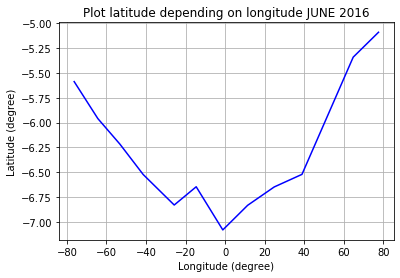

In [16]:
#ploting the coordinates
plt.title('Plot latitude depending on longitude JUNE 2016')
plt.xlabel('Longitude (degree)')
plt.ylabel('Latitude (degree)')
plt.grid(True)

plt.plot(lon_fi_june, lat_B_june, color = 'blue')  
name = 'LatLon June'
plt.savefig("Plot_"+ name +".png", format="PNG")
plt.show()

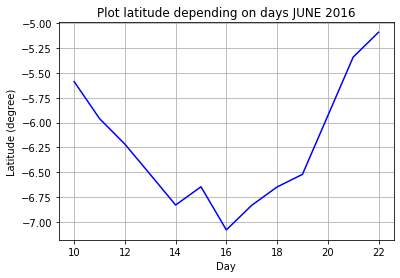

In [17]:
#ploting the coordinates
plt.title('Plot latitude depending on days JUNE 2016')
plt.xlabel('Day')
plt.ylabel('Latitude (degree)')
plt.plot(day_obs_june, lat_B_june, color = 'blue') 
plt.grid(True)
name = 'DayLat June'
plt.savefig("Plot_"+ name +".png", format="PNG")
plt.show()

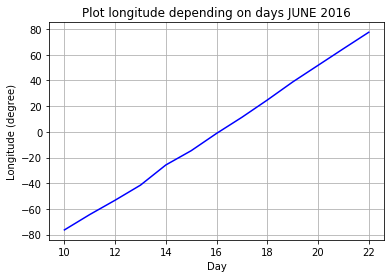

In [18]:
#ploting the coordinates
plt.title('Plot longitude depending on days JUNE 2016')
plt.xlabel('Day')
plt.ylabel('Longitude (degree)')
plt.plot(day_obs_june, lon_fi_june, color = 'blue') 
plt.grid(True)
name = 'DayLon June'
plt.savefig("Plot_"+ name +".png", format="PNG")
plt.show()

----------------------------------------------------------------------------------------------
Ploting dec data

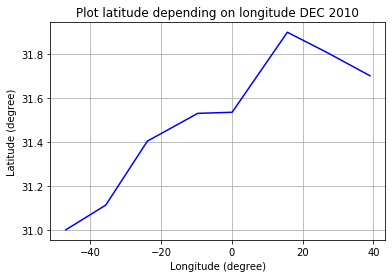

In [19]:
#ploting the coordinates
plt.title('Plot latitude depending on longitude DEC 2010')
plt.xlabel('Longitude (degree)')
plt.ylabel('Latitude (degree)')
plt.plot(lon_fi_dec, lat_B_dec, color = 'blue')  
plt.grid(True)
name = 'LatLon Dec'
plt.savefig("Plot_"+ name +".png", format="PNG")
plt.show()

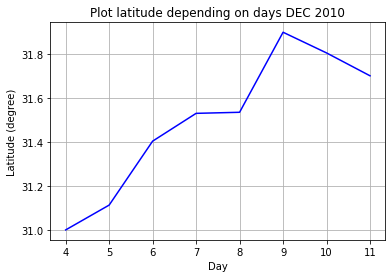

In [20]:
#ploting the coordinates
plt.title('Plot latitude depending on days DEC 2010')
plt.xlabel('Day')
plt.ylabel('Latitude (degree)')
plt.plot(day_obs_dec, lat_B_dec, color = 'blue') 
plt.grid(True)
name = 'DayLat Dec'
plt.savefig("Plot_"+ name +".png", format="PNG")
plt.show()

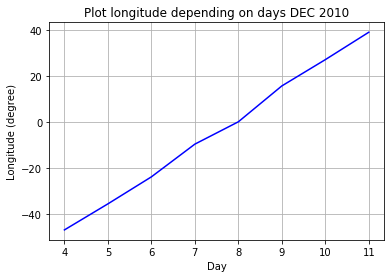

In [21]:
#ploting the coordinates
plt.title('Plot longitude depending on days DEC 2010')
plt.xlabel('Day')
plt.ylabel('Longitude (degree)')
plt.plot(day_obs_dec, lon_fi_dec, color = 'blue') 
plt.grid(True)
name = 'DayLon Dec'
plt.savefig("Plot_"+ name +".png", format="PNG")
plt.show()

In [22]:
#----Step 4----
#Determine the angular velocity of solar 
#rotation per day using the obtained 
#longitude and taking into account the time between images. 
delta_time_sec_june = calculate_delta_time_sec(DATE_OBS_june, k_june)
delta_time_sec_dec = calculate_delta_time_sec(DATE_OBS_dec, k_dec)

omega_synod_june, omega_synod_mean_june = calculate_angular_velocity(lon_fi_june, delta_time_sec_june, k_june)
omega_synod_dec, omega_synod_mean_dec = calculate_angular_velocity(lon_fi_dec, delta_time_sec_dec, k_dec)

print('Angular velocity grad per day JUNE 2016:')
for i in range(k_june-1):
    print('days ', day_obs_june[i], '-', day_obs_june[i+1], sep ='', end='  ')
    print('{0:.3f}'.format(omega_synod_june[i]), end='')
    print()

#print('V_angular_mean =', '{0:.3f}'.format(V_angular_mean_june), 'grad/day')

print('Angular velocity grad per day DECUMBER:')
for i in range(k_dec-1):
    print('days ', day_obs_dec[i], '-', day_obs_dec[i+1], sep ='', end='  ')
    print('{0:.3f}'.format(omega_synod_dec[i]))

#print('V_angular_mean =', '{0:.3f}'.format(V_angular_mean_dec), 'grad/day')

Angular velocity grad per day JUNE 2016:
days 10-11  11.503
days 11-12  12.162
days 12-13  13.521
days 13-14  13.146
days 14-15  13.156
days 15-16  13.360
days 16-17  13.350
days 17-18  13.557
days 18-19  13.203
days 19-21  13.236
days 21-22  11.967
Angular velocity grad per day DECUMBER:
days 4-5  12.634
days 5-6  12.586
days 6-7  12.508
days 7-8  12.073
days 8-9  12.939
days 9-10  12.572
days 10-11  12.394


In [23]:
#---Step 5---  Determine the sidereal rotation rate using the following relations: 
def calculate_siderial_rot (omega_synod):
    P_synod = np.zeros(k_june-1)
    P_sid = np.zeros(k_june-1)
    P_earth = 365.2564

    P_synod = 360/omega_synod
    P_sid = P_synod* P_earth /(P_earth + P_synod)
    
    #Siderial rotation rate is
    omega_sid = 360/P_sid
    return(omega_sid)

omega_sid_june = calculate_siderial_rot(omega_synod_june)
omega_sid_dec = calculate_siderial_rot(omega_synod_dec)

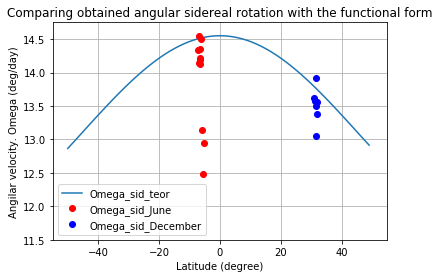

In [24]:
#--Step 6 Compare the obtained angular sidereal 
#rotation rate with the functional form of solar 
#differential rotation obtained from statistical studie

a = 14.55
b = -2.87

B = np.arange(-50,50)
Omega_sid_teor = np.zeros(len(B))

for i in range(len(B)):
    Omega_sid_teor[i] = a + b * ((math.sin(B[i]*math.pi/180))**2)

plt.title('Comparing obtained angular sidereal rotation with the functional form')
plt.axis([-55, 55, 11.5, 14.75])  # [xmin, xmax, ymin, ymax]
plt.plot(B, Omega_sid_teor)
plt.plot(lat_B_june[:-1], omega_sid_june, 'ro')
plt.plot(lat_B_dec[:-1], omega_sid_dec, 'bo')
plt.xlabel('Latitude (degree)')
plt.ylabel('Angilar velocity. Omega (deg/day)')
plt.legend(['Omega_sid_teor' ,'Omega_sid_June','Omega_sid_December'])
plt.savefig("Comparing" + ".png", format="PNG")
plt.grid(True)